In [1]:
import nltk
import pandas as pd

nltk.download('stopwords')
nltk.download('punkt')

df = pd.read_csv('./mining/reddit_clean.csv')
df['text'] = df['title'].fillna('') + ' ' + df['selftext'].fillna('')

df = df[df['created_utc'] >= 1677654056]

/Users/alirezaarvandi/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alirezaarvandi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alirezaarvandi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


2552
1793


/Users/alirezaarvandi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


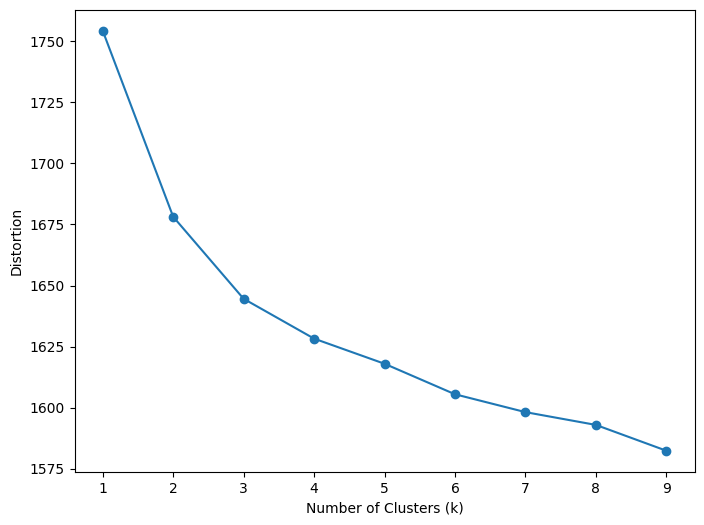

In [5]:
# Clustering using k-means tf-idf

import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()


# Removing stopwords, special characters and applying stemming & lemmatization
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    words = text.split()
    words = [word.lower() for word in words if word.lower() not in stop_words]
    words = [stemmer.stem(word) for word in words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

new_df = df.copy()

new_df['clean_text'] = df['text'].apply(preprocess_text)
new_df['token_count'] = new_df['clean_text'].apply(lambda x: len(x.split()))
print(len(new_df))
new_df = new_df[new_df['token_count'] >= 10]
print(len(new_df))

# Step 1: Text Vectorization using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(new_df['clean_text'])

# Step 2: Apply Elbow Method to find the optimal number of clusters
distortions = []
K_range = range(1, 10)  # Change the range based on your dataset

for k in K_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

In [6]:
optimal_k = 4

# Step 3: Perform K-means clustering with the optimal number of clusters
km = KMeans(n_clusters=optimal_k)
km.fit(X)

# Add cluster labels to the original DataFrame
new_df['cluster_label'] = km.labels_
distances = km.transform(X)

# For each data point, select the distance to its cluster
new_df['cluster_dist'] = [distances[i][new_df['cluster_label'].iloc[i]] for i in range(len(new_df))]

/Users/alirezaarvandi/Library/Python/3.9/lib/python/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


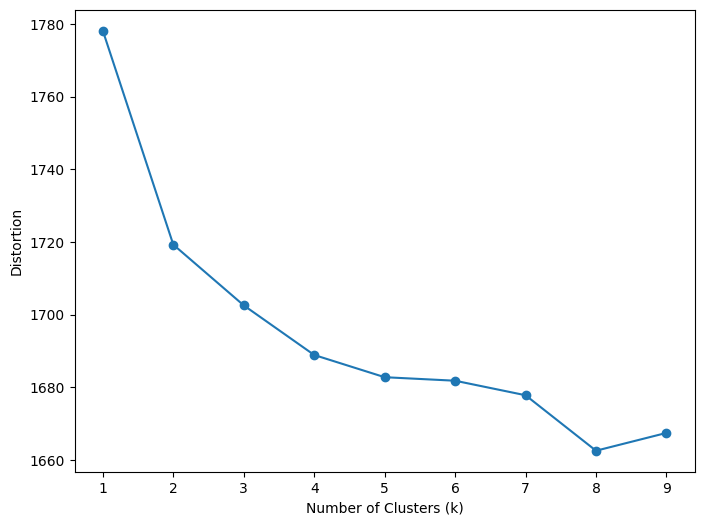

In [7]:
# Clustering using k-means with n-grams

import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Assuming the necessary preprocessing tools are already imported
# e.g., stop_words, stemmer, lemmatizer

# Removing stopwords, special characters and applying stemming & lemmatization
# def preprocess_text(text):
#     text = re.sub(r'[^\w\s]', '', text)
#     words = text.split()
#     words = [word.lower() for word in words if word.lower() not in stop_words]
#     words = [stemmer.stem(word) for word in words]
#     words = [lemmatizer.lemmatize(word) for word in words]
#     return ' '.join(words)

# new_df = df.copy()

# new_df['clean_text'] = df['text'].apply(preprocess_text)
# new_df['token_count'] = new_df['clean_text'].apply(lambda x: len(x.split()))
# print(len(new_df))
# new_df = new_df[new_df['token_count'] >= 5]
# print(len(new_df))

# Step 1: Text Vectorization using TF-IDF with n-grams
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 3)) # Using unigrams and bigrams
X = vectorizer.fit_transform(new_df['clean_text'])

# Step 2: Apply Elbow Method to find the optimal number of clusters
distortions = []
K_range = range(1, 10)  # Change the range based on your dataset

for k in K_range:
    km = KMeans(n_clusters=k)
    km.fit(X)
    distortions.append(km.inertia_)

# Plotting the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(K_range, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

In [8]:
optimal_k = 4

# Step 3: Perform K-means clustering with the optimal number of clusters
km = KMeans(n_clusters=optimal_k)
km.fit(X)

# Add cluster labels to the original DataFrame
new_df['cluster_label_n_gram'] = km.labels_
distances = km.transform(X)

# For each data point, select the distance to its cluster
new_df['cluster_dist_n_gram'] = [distances[i][new_df['cluster_label_n_gram'].iloc[i]] for i in range(len(new_df))]

In [9]:
new_df.columns
from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(new_df['cluster_label'], new_df['cluster_label_n_gram'])
print(f"Adjusted Rand Index between cluster_label and cluster_label_n_gram: {ari_score:.2f}")

ct = pd.crosstab(new_df['cluster_label'], new_df['cluster_label_n_gram'])

print(ct)

Adjusted Rand Index between cluster_label and cluster_label_n_gram: 0.95
cluster_label_n_gram    0    1   2     3
cluster_label                           
0                       0    0  80    21
1                     131    0   0     0
2                       0  131   0     2
3                       0    0   0  1428


In [10]:
for label in range(4):
    print(f"Top 5 rows for Cluster {label}:")
    subset = new_df[new_df['cluster_label'] == label]
    sorted_subset = subset.sort_values(by='cluster_dist', ascending=True).head(5)
    for i in sorted_subset['text']:
        print(i)
    print("\n")

for label in range(4):
    print(f"Top 5 rows for Cluster {label}:")
    subset = new_df[new_df['cluster_label_n_gram'] == label]
    sorted_subset = subset.sort_values(by='cluster_dist', ascending=True).head(5)
    for i in sorted_subset['text']:
        print(i)
    print("\n")

Top 5 rows for Cluster 0:
campfire ban coming soon to cariboo fire centre - quesnel cariboo observer - quesnel - cariboo observer  
campfire ban comes into effect across cariboo region - quesnel cariboo observer - quesnel - cariboo observer  
wildfire smoke impacting air quality in cariboo north thompson regions - quesnel cariboo observer - quesnel - cariboo observer  
wildfires continue to burn across cariboo fire centre - quesnel - cariboo observer  
strong winds forecast across cariboo fire centre - quesnel cariboo observer - quesnel - cariboo observer  


Top 5 rows for Cluster 1:
things to do thursdays - daily discussion welcome to /r/vancouver's things to do thursdays, a place for redditors to share and seek: * upcoming events; * volunteer opportunities; * education questions; and * job questions --- if you see commonly asked questions or posts throughout the week that you feel would be better suited to this discussion thread, please be sure to share the link to this week's post.